# Librerias

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Carga de dataset

In [ ]:
df = pd.read_csv('./df_con_aqi_nuevo.csv')

In [ ]:
df['location_name'].value_counts()

,count
location_name,
Guro-gu,190364
Nowon-gu,190051
Geumcheon-gu,189599
Gangbuk-gu,189387
Gangdong-gu,189378
Yangcheon-gu,189170
Dongjak-gu,189032
Jung-gu,188991
Seocho-gu,188842


# prediccion

## random forest

In [ ]:
df['AQI_sig'] = df.groupby('location_name')['AQI'].shift(-1)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df['dt']=pd.to_datetime(df['dt'])

In [ ]:
df['month'] = df['dt'].dt.month

In [ ]:
df.set_index('dt', inplace=True)

In [ ]:
X = df[['so2', 'no2', 'co', 'o3', 'pm10', 'pm2.5', 'month',
        'holiday', 'is_daytime', 'traffic_peak', 'distance_to_center']]
y = df['AQI_sig']

In [ ]:
test_size = int(len(df) * 0.3)

In [ ]:
dummy = df.iloc[-test_size:]
last_week = dummy.index

In [ ]:
features = ['so2', 'no2', 'co', 'o3', 'pm10', 'pm2.5', 'month',
        'holiday', 'is_daytime', 'traffic_peak', 'distance_to_center']

In [ ]:
X_train = df.iloc[:-test_size][features]
y_train = df.iloc[:-test_size]['AQI_sig']

X_test = df.iloc[-test_size:][features]
y_test = df.iloc[-test_size:]['AQI_sig']

In [ ]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(X_train.mean(), inplace=True)

X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
scaler_target = StandardScaler()
y_test = scaler_target.fit_transform(y_test.values.reshape(-1, 1))
y_train = scaler_target.fit_transform(y_train.values.reshape(-1, 1))

In [ ]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

In [ ]:
model.fit(X_train, y_train)

c:\Users\jafet\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=10, random_state=42)

In [ ]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1))

mse = mean_squared_error(y_test, y_pred_scaled)
print("Error cuadrático medio (MSE):", mse)

Error cuadrático medio (MSE): 0.16862486707505878


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(y_test, y_pred_scaled)
mae = mean_absolute_error(y_test, y_pred_scaled)

print("Coeficiente de Determinación (R^2):", r2)
print("Error Absoluto Medio (MAE):", mae)

Coeficiente de Determinación (R^2): 0.8313751329249413
Error Absoluto Medio (MAE): 0.31573600046100103


In [ ]:
last_week

DatetimeIndex(['2015-06-28 12:00:00', '2015-06-28 12:00:00',
               '2015-06-28 12:00:00', '2015-06-28 12:00:00',
               '2015-06-28 12:00:00', '2015-06-28 12:00:00',
               '2015-06-28 12:00:00', '2015-06-28 12:00:00',
               '2015-06-28 12:00:00', '2015-06-28 12:00:00',
               ...
               '2021-12-31 22:00:00', '2021-12-31 22:00:00',
               '2021-12-31 22:00:00', '2021-12-31 22:00:00',
               '2021-12-31 22:00:00', '2021-12-31 22:00:00',
               '2021-12-31 22:00:00', '2021-12-31 22:00:00',
               '2021-12-31 22:00:00', '2021-12-31 22:00:00'],
              dtype='datetime64[ns]', name='dt', length=1402827, freq=None)

In [ ]:
y_test = scaler_target.inverse_transform(y_test).flatten()

In [ ]:
y_test = pd.Series(y_test, index=last_week)
y_pred = pd.Series(y_pred.flatten(), index=last_week)

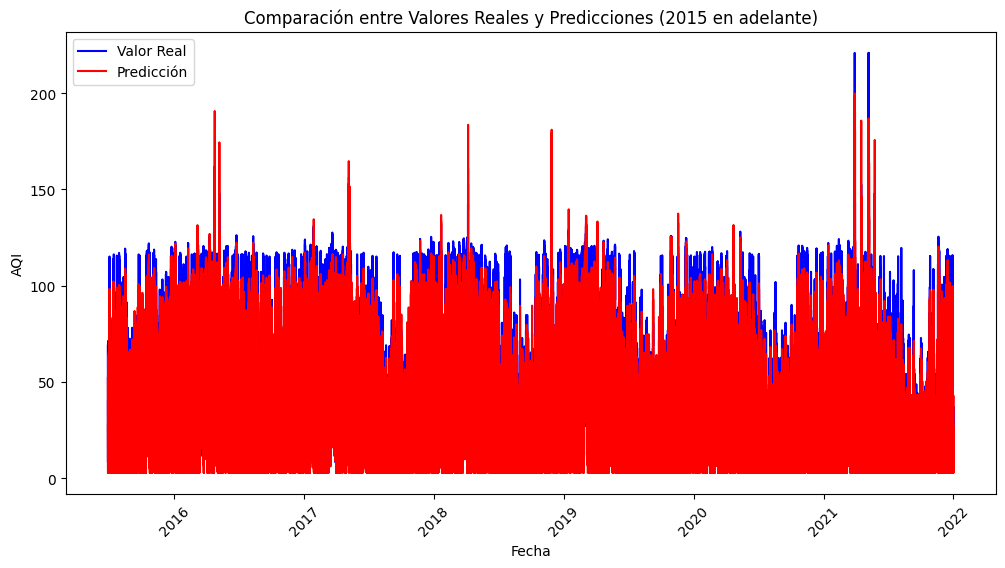

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Valor Real', color='blue')
plt.plot(y_test.index, y_pred, label='Predicción', color='red')
plt.xlabel('Fecha')
plt.ylabel('AQI')
plt.title('Comparación entre Valores Reales y Predicciones (2015 en adelante)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
def predecir_aqi(data, features, model, scaler, scaler_target, first_date):
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(data.mean(), inplace=True)

    X_last = data[features].copy().values.reshape(1, -1)

    df_pred_scaled = scaler.transform(X_last)
    prediccion_aqi = model.predict(df_pred_scaled)
    print(prediccion_aqi)

    prediccion_aqi_desescalada = scaler_target.inverse_transform(np.array(prediccion_aqi[0]).reshape(-1, 1))[0][0]

    predicciones_df = pd.DataFrame({
        "Fecha": [first_date + pd.Timedelta(hours=1)],
        "AQI_Predicho": [prediccion_aqi_desescalada]
    })

    return predicciones_df

### jongno gu

In [ ]:
data_13_nov_3am = pd.DataFrame({
    'so2': [0.002],
    'co': [0.567],
    'no2': [0.028],
    'o3': [0.10],
    'pm10': [35],
    'pm2.5': [21],
    'month': [11],
    'holiday': [False],
    'is_daytime': [False],
    'traffic_peak': [False],
    'distance_to_center': [2.3]
})

In [ ]:
first_date = pd.Timestamp("2024-11-13 03:08:00")
predicciones_df = predecir_aqi(data_13_nov_3am, features, model, scaler, scaler_target, first_date)
print(predicciones_df)

[0.38080042]
                Fecha  AQI_Predicho
0 2024-11-13 04:08:00     48.150803


c:\Users\jafet\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\jafet\AppData\Local\Temp\ipykernel_1348\2294935778.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "Fecha": pd.date_range(start=first_date + pd.Timedelta(hours=1), periods=1, freq='H'),


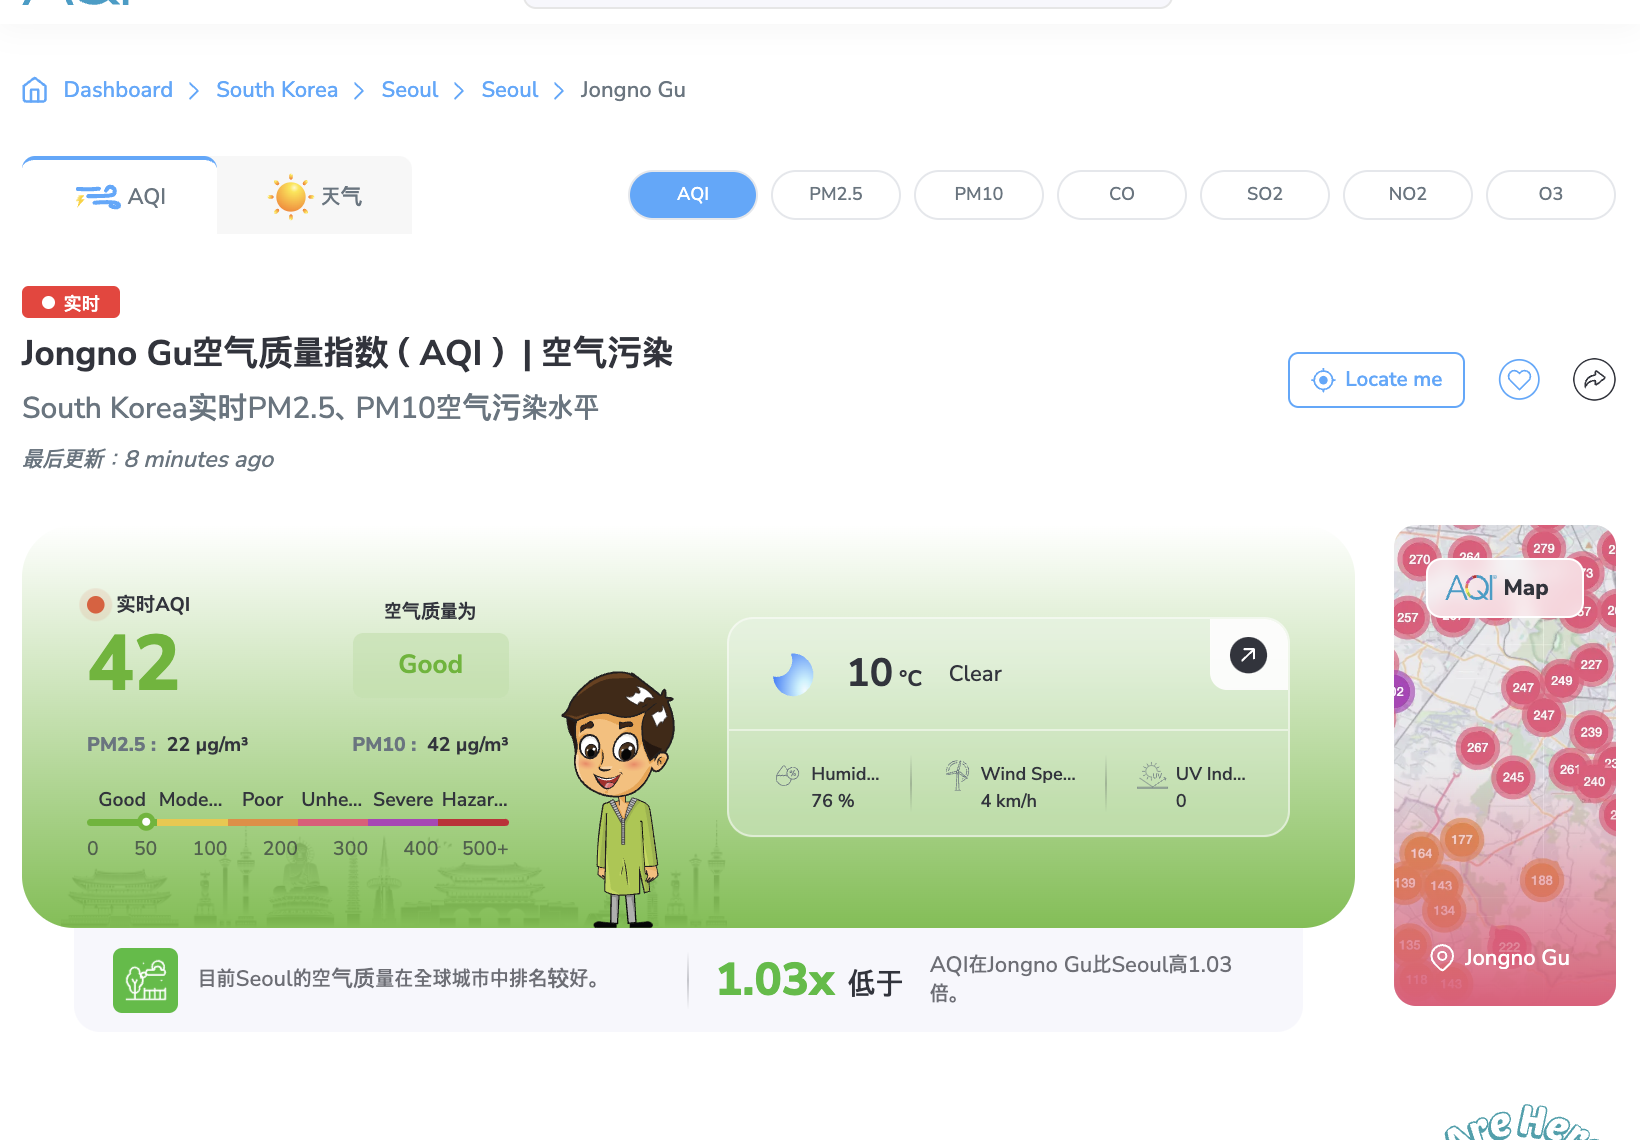

### seodaemun gu

In [ ]:
data_13_nov_3_am = pd.DataFrame({
    'so2': [0.003],
    'co': [0.667],
    'no2': [0.025],
    'o3': [0.012],
    'pm10': [37],
    'pm2.5': [21],
    'month': [11],
    'holiday': [False],
    'is_daytime': [False],
    'traffic_peak': [False],
    'distance_to_center': [4]
})

In [ ]:
first_date = pd.Timestamp("2024-11-13 03:08:00")
predicciones_df = predecir_aqi(data_13_nov_3am, features, model, scaler, scaler_target, first_date)
print(predicciones_df)

[-0.30326721]
                Fecha  AQI_Predicho
0 2024-11-13 04:08:00     28.969261


c:\Users\jafet\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\jafet\AppData\Local\Temp\ipykernel_1348\1971262543.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "Fecha": pd.date_range(start=first_date + pd.Timedelta(hours=1), periods=1, freq='H'),


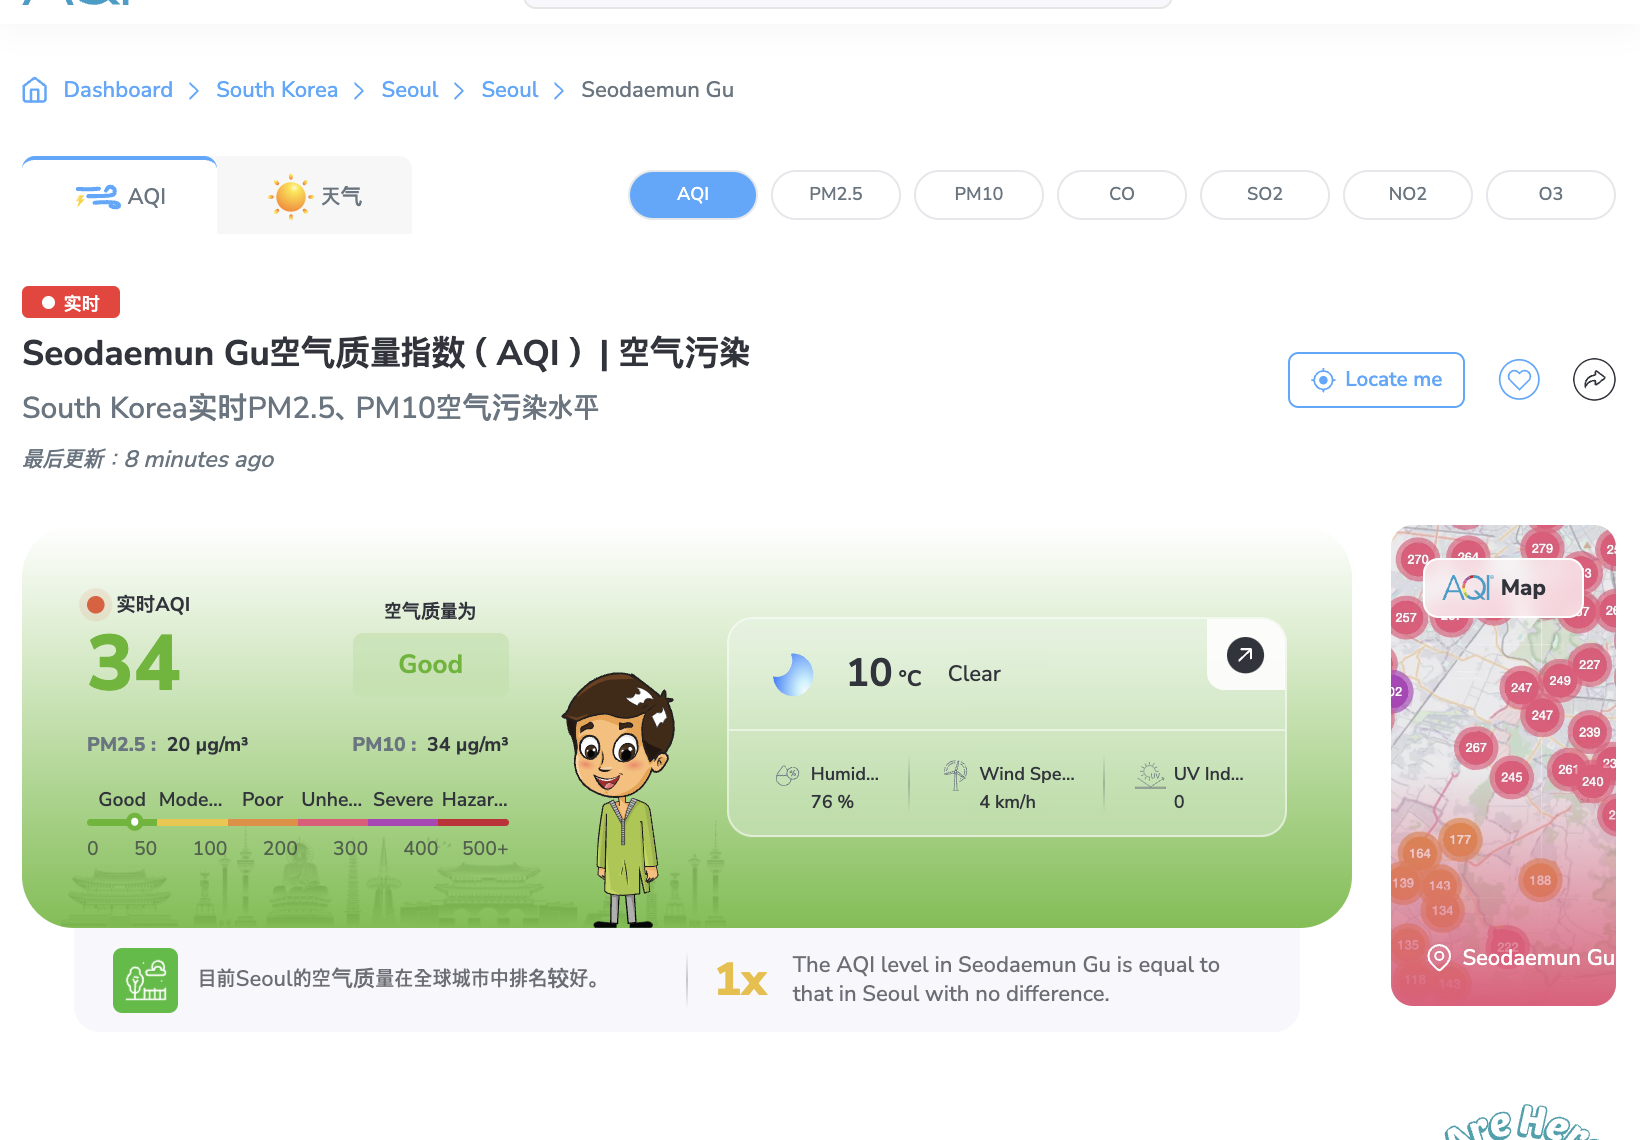

In [ ]:
# download model
import joblib
joblib.dump(model, 'modelo_sin_tuning_rf_arreglado.pkl')

['modelo_sin_tuning_rf_arreglado.pkl']

In [ ]:
joblib.dump(scaler, 'scaler_arreglado.pkl')
joblib.dump(scaler_target, 'scaler_target_arreglado.pkl')

['scaler_target_arreglado.pkl']

### tuning

In [ ]:
from skopt import BayesSearchCV
from skopt.callbacks import VerboseCallback
from sklearn.ensemble import RandomForestRegressor

model_tun = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': (50, 75),
    'max_depth': (5, 7),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 5),
    'max_features': ['log2', 'sqrt']
}


In [ ]:
opt = BayesSearchCV(
    estimator=model_tun,
    search_spaces=param_grid,
    n_iter=8,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=0,
)

In [ ]:
opt.fit(X_train, y_train, callback=VerboseCallback(n_total=8))

print("Mejores parámetros encontrados:", opt.best_params_)
print("Mejor puntaje de validación:", -opt.best_score_)

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 573.9833
Function value obtained: 0.1814
Current minimum: 0.1814
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 455.0253
Function value obtained: 0.2023
Current minimum: 0.1814
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 350.2149
Function value obtained: 0.2030
Current minimum: 0.1814
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 413.3081
Function value obtained: 0.1829
Current minimum: 0.1814
Iteration No: 5 started. Searching for the next optimal point.


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 499.2724
Function value obtained: 0.1823
Current minimum: 0.1814
Iteration No: 6 started. Searching for the next optimal point.


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 365.1294
Function value obtained: 0.1832
Current minimum: 0.1814
Iteration No: 7 started. Searching for the next optimal point.


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 388.0930
Function value obtained: 0.2034
Current minimum: 0.1814
Iteration No: 8 started. Searching for the next optimal point.
Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 358.4589
Function value obtained: 0.2289
Current minimum: 0.1814


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mejores parámetros encontrados: OrderedDict([('max_depth', 7), ('max_features', 'sqrt'), ('min_samples_leaf', 3), ('min_samples_split', 8), ('n_estimators', 72)])
Mejor puntaje de validación: 0.18138158609197827


In [ ]:
joblib.dump(opt, 'modelo_optimizado_2.pkl')

['modelo_optimizado_2.pkl']

In [ ]:
y_pred_scaled = opt.predict(X_test)

In [ ]:
y_test_new = df.iloc[-test_size:]['AQI_sig']
y_test_new = scaler_target.fit_transform(y_test_new.values.reshape(-1, 1))

In [ ]:
mse = mean_squared_error(y_test_new, y_pred_scaled)
print("Error cuadrático medio (MSE):", mse)

Error cuadrático medio (MSE): 0.17355810010741346


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
r2 = r2_score(y_test_new, y_pred_scaled)
mae = mean_absolute_error(y_test_new, y_pred_scaled)

print("Coeficiente de Determinación (R^2):", r2)
print("Error Absoluto Medio (MAE):", mae)

Coeficiente de Determinación (R^2): 0.8264418998925865
Error Absoluto Medio (MAE): 0.30839137938209504


In [ ]:
y_pred_new = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_new = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1))

In [ ]:
y_test_new = pd.Series(y_test_new.flatten(), index=last_week)
y_pred_new = pd.Series(y_pred_new.flatten(), index=last_week)

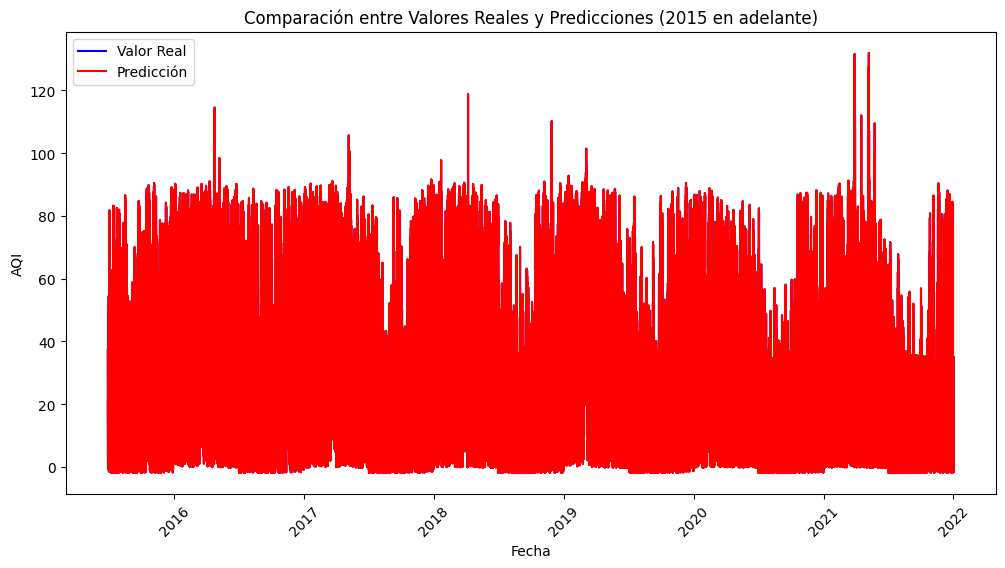

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_new.index, y_test_new, label='Valor Real', color='blue')
plt.plot(y_test_new.index, y_pred_new, label='Predicción', color='red')
plt.xlabel('Fecha')
plt.ylabel('AQI')
plt.title('Comparación entre Valores Reales y Predicciones (2015 en adelante)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

#### jongno gu

In [ ]:
data_13_nov_4am = pd.DataFrame({
    'so2': [0.002],
    'co': [0.567],
    'no2': [0.034],
    'o3': [0.003],
    'pm10': [42],
    'pm2.5': [22],
    'month': [11],
    'holiday': [False],
    'is_daytime': [False],
    'traffic_peak': [False],
    'distance_to_center': [2.3]
})

In [ ]:
first_date = pd.Timestamp("2024-11-13 04:47:00")
predicciones_df = predecir_aqi(data_13_nov_4am, features, model, scaler, scaler_target, first_date)
print(predicciones_df)

[-0.09030559]
                Fecha  AQI_Predicho
0 2024-11-13 05:47:00     25.109476


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
<ipython-input-61-f2f7737e80c2>:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "Fecha": pd.date_range(start=first_date + pd.Timedelta(hours=1), periods=1, freq='H'),


#### seodaemun gu

In [ ]:
data_13_nov_4am = pd.DataFrame({
    'so2': [0.003],
    'co': [0.667],
    'no2': [0.023],
    'o3': [0.009],
    'pm10': [34],
    'pm2.5': [20],
    'month': [11],
    'holiday': [False],
    'is_daytime': [False],
    'traffic_peak': [False],
    'distance_to_center': [4]
})

In [ ]:
first_date = pd.Timestamp("2024-11-13 04:41:00")
predicciones_df = predecir_aqi(data_13_nov_4am, features, model, scaler, scaler_target, first_date)
print(predicciones_df)

[-0.3050251]
                Fecha  AQI_Predicho
0 2024-11-13 05:41:00     19.414302


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
<ipython-input-63-e14f2ae10fc4>:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "Fecha": pd.date_range(start=first_date + pd.Timedelta(hours=1), periods=1, freq='H'),


## XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
X = df[['so2', 'no2', 'co', 'o3', 'pm10', 'pm2.5', 'month',
        'holiday', 'is_daytime', 'traffic_peak', 'distance_to_center']]
y = df['AQI_sig']
test_size = int(len(df) * 0.3)
dummy = df.iloc[-test_size:]
last_week = dummy.index
features = ['so2', 'no2', 'co', 'o3', 'pm10', 'pm2.5', 'month',
        'holiday', 'is_daytime', 'traffic_peak', 'distance_to_center']
X_train = df.iloc[:-test_size][features]
y_train = df.iloc[:-test_size]['AQI_sig']

X_test = df.iloc[-test_size:][features]
y_test = df.iloc[-test_size:]['AQI_sig']
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(X_train.mean(), inplace=True)

X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

scaler_target = StandardScaler()
y_test = scaler_target.fit_transform(y_test.values.reshape(-1, 1))
y_train = scaler_target.fit_transform(y_train.values.reshape(-1, 1))

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

In [ ]:
num_boost_round = 100
watchlist = [(dtrain, 'train'), (dtest, 'test')]

model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=10)

[0]	train-rmse:0.91973	test-rmse:0.91594
[1]	train-rmse:0.88622	test-rmse:0.87997
[2]	train-rmse:0.81847	test-rmse:0.80845
[3]	train-rmse:0.76901	test-rmse:0.75080
[4]	train-rmse:0.71500	test-rmse:0.69456
[5]	train-rmse:0.66489	test-rmse:0.64388
[6]	train-rmse:0.64732	test-rmse:0.62760
[7]	train-rmse:0.60810	test-rmse:0.58779
[8]	train-rmse:0.58128	test-rmse:0.55615
[9]	train-rmse:0.54875	test-rmse:0.52498
[10]	train-rmse:0.52403	test-rmse:0.50155
[11]	train-rmse:0.49988	test-rmse:0.48028
[12]	train-rmse:0.48079	test-rmse:0.46388
[13]	train-rmse:0.46433	test-rmse:0.44935
[14]	train-rmse:0.45053	test-rmse:0.43773
[15]	train-rmse:0.43851	test-rmse:0.42871
[16]	train-rmse:0.42750	test-rmse:0.42090
[17]	train-rmse:0.42038	test-rmse:0.41343
[18]	train-rmse:0.41227	test-rmse:0.40775
[19]	train-rmse:0.40552	test-rmse:0.40420
[20]	train-rmse:0.39975	test-rmse:0.40122
[21]	train-rmse:0.39516	test-rmse:0.39921
[22]	train-rmse:0.39148	test-rmse:0.39783
[23]	train-rmse:0.38902	test-rmse:0.39571
[2

In [ ]:
y_pred = model.predict(dtest)

In [ ]:
y_pred = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

MSE: 123.19367021127107
MAE: 8.4070863941133
R2: 0.8433178779201809


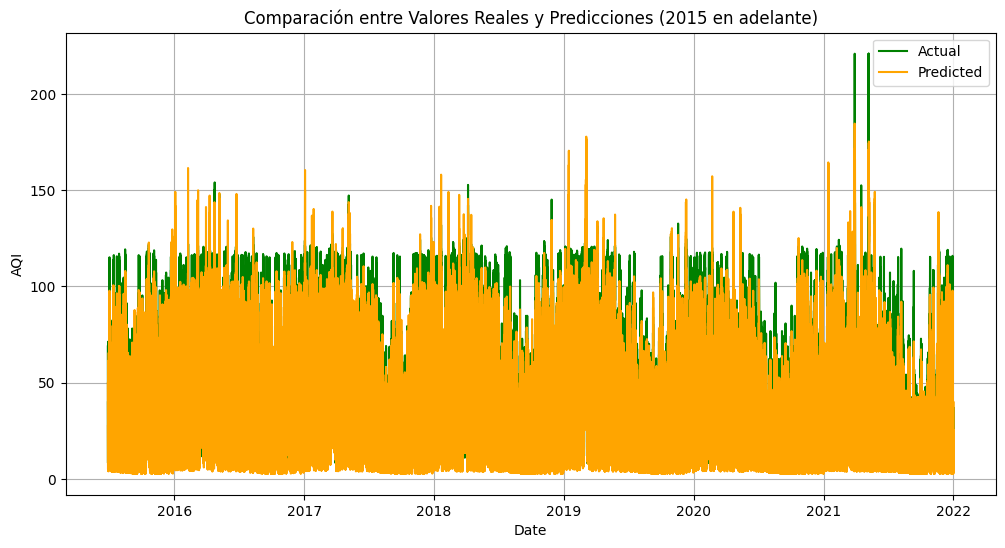

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(last_week, y_test_original, label="Actual",color='green')
plt.plot(last_week, y_pred, label="Predicted", color='orange')
plt.xlabel("Date")
plt.ylabel("AQI")
plt.title('Comparación entre Valores Reales y Predicciones (2015 en adelante)')
plt.legend()
plt.grid()
plt.show()

### Tuning

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Crear DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Función objetivo para Optuna
def objective(trial):
    # Hiperparámetros a optimizar
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),  # Learning rate
        'max_depth': trial.suggest_int('max_depth', 3, 10),       # Profundidad máxima
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),  # Peso mínimo de hojas
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Fracción de datos
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Fracción de características
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),  # Regularización L2
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),    # Regularización L1
    }

    # Entrenar modelo con validación temprana
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtest, "validation")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Predicción y evaluación
    y_pred = model.predict(dtest)
    y_pred = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
    y_test_original = scaler_target.inverse_transform(y_test)

    # Retornar el MSE como métrica a minimizar
    return mean_squared_error(y_test_original, y_pred)

# Crear estudio Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Resultados del mejor modelo
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

# Entrenar modelo final con los mejores parámetros
final_model = xgb.train(
    {**best_params, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'},
    dtrain,
    num_boost_round=1000,
    evals=[(dtest, "validation")],
    early_stopping_rounds=50,
    verbose_eval=False
)

# Predicción final
y_pred = final_model.predict(dtest)
y_pred = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_target.inverse_transform(y_test)

# Métricas finales
mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
print(f"Resultados finales -> MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


In [ ]:
from skopt import BayesSearchCV
from skopt.callbacks import VerboseCallback
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from joblib import dump

# Dividir los datos en conjuntos de entrenamiento y prueba nuevamente (si es necesario)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Modelo base
model_tun = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Espacio de búsqueda
param_grid = {
    'n_estimators': (50, 150),  # Número de árboles
    'max_depth': (3, 10),       # Profundidad máxima del árbol
    'learning_rate': (0.01, 0.3, 'log-uniform'),  # Tasa de aprendizaje
    'subsample': (0.5, 1.0),    # Fracción de datos para entrenar cada árbol
    'colsample_bytree': (0.5, 1.0),  # Fracción de características para entrenar cada árbol
    'min_child_weight': (1, 10),  # Peso mínimo para una hoja
}

# Configuración de BayesSearchCV
opt = BayesSearchCV(
    estimator=model_tun,
    search_spaces=param_grid,
    n_iter=25,  # Número de iteraciones de búsqueda
    cv=3,  # Validación cruzada
    n_jobs=-1,  # Usa todos los núcleos disponibles
    scoring='neg_mean_squared_error',
    verbose=0,
)

# Entrenamiento del modelo con optimización bayesiana
opt.fit(X_train_split, y_train_split, callback=VerboseCallback(n_total=25))

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", opt.best_params_)
print("Mejor puntaje de validación (neg MSE):", -opt.best_score_)

# Predicción en el conjunto de prueba
y_pred = opt.best_estimator_.predict(X_test)

# Inversión del escalado
y_pred = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_target.inverse_transform(y_test)

# Evaluación final
mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
print(f"Resultados finales -> MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

# Guardar el modelo optimizado
dump(opt, 'xgboost_model_optimizado.pkl')


Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 80.7489
Function value obtained: 0.1333
Current minimum: 0.1333
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 52.2371
Function value obtained: 0.1314
Current minimum: 0.1314
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 63.8978
Function value obtained: 0.1318
Current minimum: 0.1314
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 26.2413
Function value obtained: 0.2012
Current minimum: 0.1314
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 62.9930
Function value obtained: 0

['xgboost_model_optimizado.pkl']

In [ ]:
y_pred_scaled = opt.predict(X_test)